# Bin Buddies 

### COSC 325 Introduction to Machine Learning
#### Group 15
#### Mia Patrikios, Yves Song, Hezekiah McDonald, Isaiah Weaver, Nia Maheshwari
---

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns

# processing images with tensorflow 
# run 'pip install tensorflow' if module not found
import tensorflow as tf


from scipy import stats
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import zipfile
from tqdm import tqdm

# Random generator
rng1 = np.random.RandomState(seed=123)

ModuleNotFoundError: No module named 'tensorflow'

### One-Hot-Encoding Data

* new columns for the first five labels
* 0 or 1 values to indicate what category a sample belongs to

In [34]:
train_data = pd.read_csv("data/metadata.csv")
test_data = pd.read_csv("data/metadata.csv")

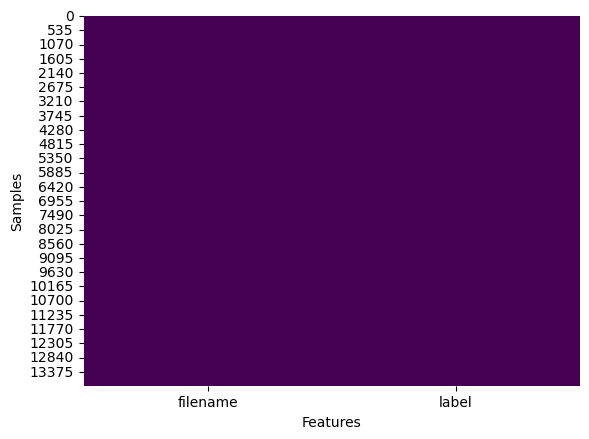

In [31]:
# checking for missing data in samples

sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.ylabel('Samples')
plt.xlabel('Features')
plt.show()

In [32]:
# one-hot-encoding data (all but last col) 

train_data['cardboard'] = train_data['label'].apply(lambda x: 1 if x=='cardboard' else 0)
train_data['glass'] = train_data['label'].apply(lambda x: 1 if x=='glass' else 0)
train_data['plastic'] = train_data['label'].apply(lambda x: 1 if x=='plastic' else 0)
train_data['metal'] = train_data['label'].apply(lambda x: 1 if x=='metal' else 0)
train_data['paper'] = train_data['label'].apply(lambda x: 1 if x=='paper' else 0)
train_data = train_data.drop(columns='label')

train_data.head()

,filename,cardboard,glass,plastic,metal,paper
0,cardboard_02038.jpg,1,0,0,0,0
1,cardboard_02320.jpg,1,0,0,0,0
2,cardboard_01728.jpg,1,0,0,0,0
3,cardboard_00093.jpg,1,0,0,0,0
4,cardboard_00094.jpg,1,0,0,0,0


In [33]:
# one-hot-encoding data (all but last col) 

test_data['cardboard'] = test_data['label'].apply(lambda x: 1 if x=='cardboard' else 0)
test_data['glass'] = test_data['label'].apply(lambda x: 1 if x=='glass' else 0)
test_data['plastic'] = test_data['label'].apply(lambda x: 1 if x=='plastic' else 0)
test_data['metal'] = test_data['label'].apply(lambda x: 1 if x=='metal' else 0)
test_data['paper'] = test_data['label'].apply(lambda x: 1 if x=='paper' else 0)
test_data = test_data.drop(columns='label')

train_data.head()

,filename,cardboard,glass,plastic,metal,paper
0,cardboard_02038.jpg,1,0,0,0,0
1,cardboard_02320.jpg,1,0,0,0,0
2,cardboard_01728.jpg,1,0,0,0,0
3,cardboard_00093.jpg,1,0,0,0,0
4,cardboard_00094.jpg,1,0,0,0,0


### Data Preprocessing Pipeline

* Resize images to make them all have the same shape (e.g., 128x128x3 or 224x224x3).
* Normalize pixel values by scaling pixel intensities (from [0,255] to [0,1] or [-1,1], for example)
* Data augmentation (optional) such as random rotations, flips, zooms, brightness shifts to improve generalization.
* batching samples by converting dataset into batches for training

In [ ]:
def load_image(path):

In [ ]:
def resize_image(img):

In [ ]:
def normalize_image(img):

In [ ]:
def preprocess(path, label):